# Regression task

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from skorch.callbacks import EarlyStopping
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
train_df = pd.read_csv('regression_dataset/train_data.csv',names=("input","label"))
test_df  = pd.read_csv('regression_dataset/test_data.csv', names=("input","label"))

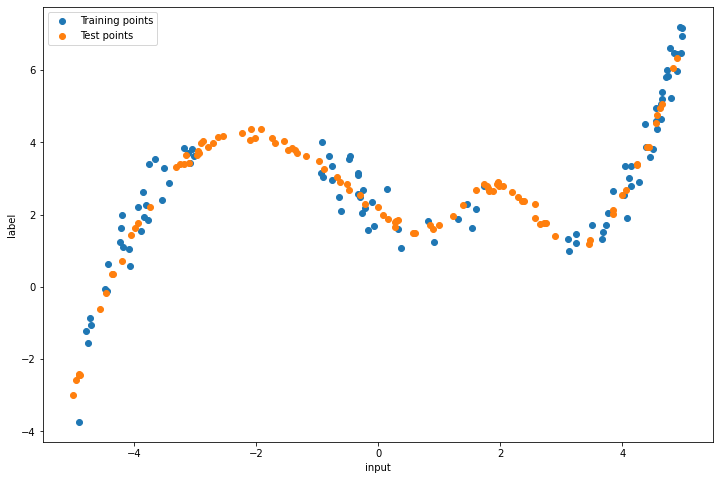

In [3]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input,  test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

Apparently skorch does not support the Pytorch Dataset class to pass the data so we just have to do it in the old way.

Prepare the training and test dataset moving from dataframe -> numpy -> PyTorch tensor

In [4]:
x_train, y_train = train_df.input.values, train_df.label.values
x_test,  y_test  = test_df.input.values,  test_df.label.values

#convert to Pytorch tensor
x_train, y_train = np.expand_dims(x_train, axis=1), np.expand_dims(y_train, axis=1)
x_test,  y_test  = np.expand_dims(x_test, axis=1),  np.expand_dims(y_test, axis=1)

x_train, y_train = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
x_test,  y_test  = torch.from_numpy(x_test).float(),  torch.from_numpy(y_test).float()

## Network definition

In [5]:
#Define the network class
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No,drop):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        #Define the network layers
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.dr1 = nn.Dropout(p=drop) 
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        
        #The activation function is not included in the layers
        #(nn.Linear in this case)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()    #i observe better results using Relu
        self.name="Net"
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x

In [6]:
#Define early stopping
early_stop = EarlyStopping(
             monitor   = "valid_loss",
             patience  = 200,
             threshold = 1e-5,
             threshold_mode  ="rel",
             lower_is_better = True)

### Grid search using Skorch

In [11]:
#Prepare the network for the gridsearch using Skorch
#This can be useful when you want to change certain parameters using a callback,
#when using the net in an sklearn grid search, etc.

net_skorch = NeuralNetRegressor(
             module      = Net,
             module__Ni  = 1,
             module__Nh1 = 128,
             module__Nh2 = 256,
             module__No  = 1,
             module__drop = 0.01,           #use drop as regularization
             max_epochs    = 2000,
             optimizer     = optim.Adam,     #Optimizer
             optimizer__lr = 0.01,           #Learning rate
             optimizer__weight_decay = 1e-5, #Weight decay based on L2 norm
             #optimizer__momentum     = 1e-4, #Add momentum 
             criterion     = nn.MSELoss,     #Loss function
             callbacks     = [early_stop],
             verbose = 0
    )

In [12]:
#Define the search space for the grid
params = {
    "module__Nh1": [25,50,75,100],
    "module__Nh2": [25,50,75,100],
    "module__drop":[0.001,0.5],
    }
    #"max_epochs":  [1000],
    #"lr":          [1e-4,1e-3,1e-2],
    #"optimizer__weight_decay": [1e-5],
    #"optimizer__momentum":     [0,1e-4],
    #"optimizer": [optim.SGD]
#}


In [13]:
#For the cross validation cv specifies the number of folds in a (Stratified)KFold
k_fold = 5

gs = GridSearchCV(net_skorch, params, refit=True, cv=k_fold, scoring='neg_mean_squared_error',verbose=2)


In [14]:
gs.fit(x_train,y_train)
print(gs.best_score_, gs.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Network initialized
[CV] END .module__Nh1=25, module__Nh2=25, module__drop=0.001; total time=   0.7s
Network initialized
[CV] END .module__Nh1=25, module__Nh2=25, module__drop=0.001; total time=   1.0s
Network initialized
[CV] END .module__Nh1=25, module__Nh2=25, module__drop=0.001; total time=   2.3s
Network initialized
[CV] END .module__Nh1=25, module__Nh2=25, module__drop=0.001; total time=   3.0s
Network initialized
[CV] END .module__Nh1=25, module__Nh2=25, module__drop=0.001; total time=   4.4s
Network initialized
[CV] END ...module__Nh1=25, module__Nh2=25, module__drop=0.5; total time=   1.0s
Network initialized
[CV] END ...module__Nh1=25, module__Nh2=25, module__drop=0.5; total time=   1.0s
Network initialized
[CV] END ...module__Nh1=25, module__Nh2=25, module__drop=0.5; total time=   1.5s
Network initialized
[CV] END ...module__Nh1=25, module__Nh2=25, module__drop=0.5; total time=   1.7s
Network initialized
[CV] END 

[CV] END .module__Nh1=75, module__Nh2=25, module__drop=0.001; total time=   0.8s
Network initialized
[CV] END .module__Nh1=75, module__Nh2=25, module__drop=0.001; total time=   2.1s
Network initialized
[CV] END .module__Nh1=75, module__Nh2=25, module__drop=0.001; total time=   2.3s
Network initialized
[CV] END .module__Nh1=75, module__Nh2=25, module__drop=0.001; total time=   3.3s
Network initialized
[CV] END ...module__Nh1=75, module__Nh2=25, module__drop=0.5; total time=   0.6s
Network initialized
[CV] END ...module__Nh1=75, module__Nh2=25, module__drop=0.5; total time=   0.9s
Network initialized
[CV] END ...module__Nh1=75, module__Nh2=25, module__drop=0.5; total time=   1.4s
Network initialized
[CV] END ...module__Nh1=75, module__Nh2=25, module__drop=0.5; total time=   2.4s
Network initialized
[CV] END ...module__Nh1=75, module__Nh2=25, module__drop=0.5; total time=   5.2s
Network initialized
[CV] END .module__Nh1=75, module__Nh2=50, module__drop=0.001; total time=   0.8s
Network in

In [15]:
#set the best model
chosen_net = gs.best_estimator_
print(chosen_net)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=1, out_features=25, bias=True)
    (dr1): Dropout(p=0.001, inplace=False)
    (fc2): Linear(in_features=25, out_features=25, bias=True)
    (out): Linear(in_features=25, out_features=1, bias=True)
    (sig): Sigmoid()
    (relu): ReLU()
  ),
)


In [16]:
chosen_net.fit(x_train, y_train)

Network initialized


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=1, out_features=25, bias=True)
    (dr1): Dropout(p=0.001, inplace=False)
    (fc2): Linear(in_features=25, out_features=25, bias=True)
    (out): Linear(in_features=25, out_features=1, bias=True)
    (sig): Sigmoid()
    (relu): ReLU()
  ),
)

In [17]:
#Retrieve train loss and validation loss for all epochs to check its evolution
history        = chosen_net.history
train_loss_log = history[:, 'train_loss']
val_loss_log   = history[:, 'valid_loss']

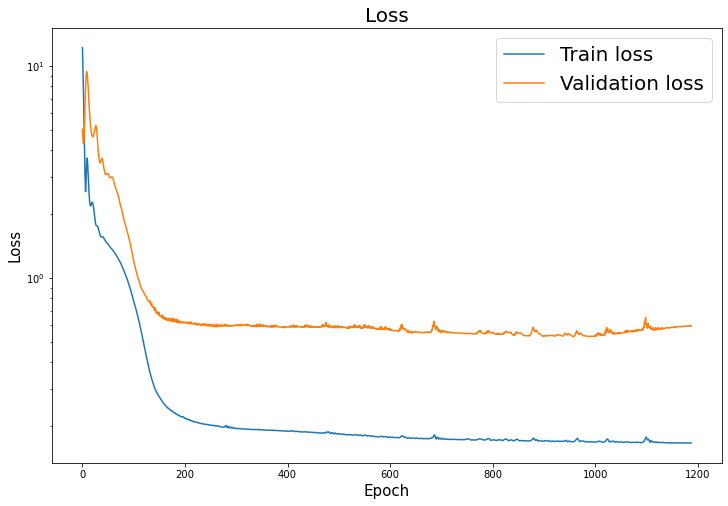

In [23]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log)
plt.semilogy(val_loss_log)
plt.title('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(['Train loss', 'Validation loss'], loc='best', fontsize = 20)
plt.savefig("regularization_Losses.png")
plt.show()

### Best model predictions

In [19]:
#Predict values for the test set
y_pred = chosen_net.predict(x_test)
y_pred = torch.from_numpy(y_pred).float()

In [20]:
#As the x values are not ordered we order it with the corresponding y predictions for plotting purpose
zipped_lists = zip(x_test, y_pred)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
x, y = [ list(tuple) for tuple in  tuples]

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


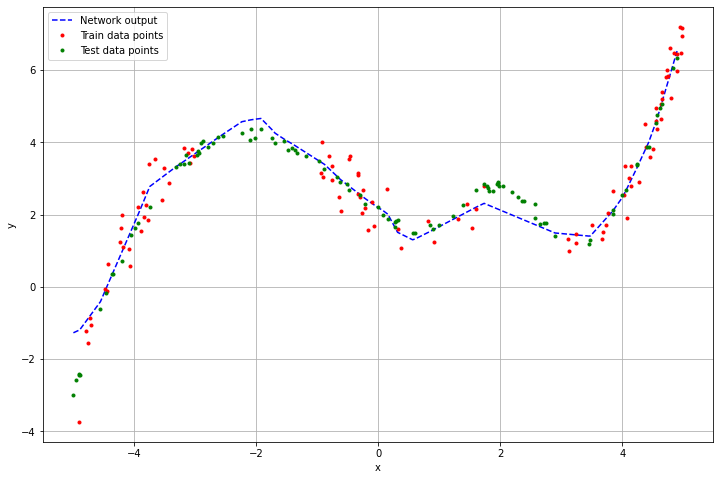

In [21]:
# Plot output
plt.figure(figsize=(12,8))
plt.plot(x, y, color='b', ls='--', label='Network output')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_test,  y_test, color='g', ls='', marker='.', label='Test data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

In [18]:
#Access network parameters
net = chosen_net.module_

In [19]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

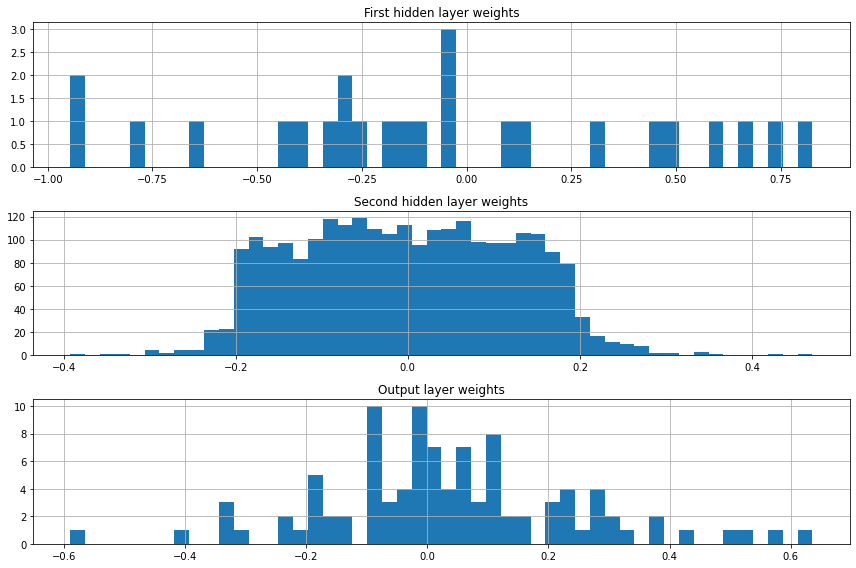

In [20]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [21]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


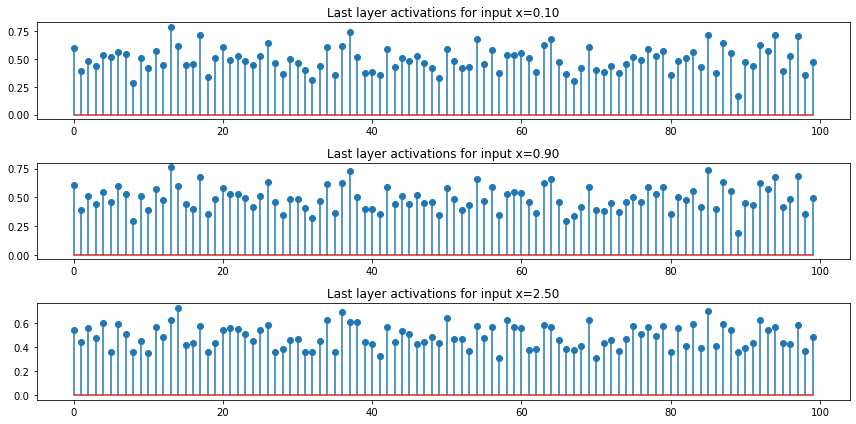

In [22]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()